# hillmaker - OO design ideas

Overall application design goals and objectives

- should be easy to run a scenario and get all the standard outputs
- scenario specific settings should be persistable as something like a json file
- should be possible to generate only outputs wanted
- should have a CLI
- should be importable so that it can be used from notebook or other custom Python scripts
- be nice to have a GUI for non-technie users
- should be easy to explore multiple scenarios
- global and scenario specific settings can be managed through settings files, command line args or function args
- current occupancy, arrival and departure stats all still desirable
- los summary would be nice
- outputs should be in formats that lend themselves to further analysis and reporting such as csvs for the occ stats (bydatetime and summary), standard graphic file formats, perhaps JSON for los summary and occ stats
- dataset profiling should be done to identify potential issues with horizon effects, warmup effects, missing data periods, or other anomolies.


Should hillmaker be redesigned as an OO based application?

- does OO design make for a better analyst experience? For example, does OO make it easier to create and manage a bunch of scenarios in which each is a separate hillmaker run? OO would make it easier to document scenarios through their settings (e.g. as json file).
- does OO lead to potential performance gains by making it easier to only run the parts we want to run. For example, maybe we don't want individual day of week plots.
- right now hillmaker is an (almost) all or nothing experience with each run standing alone. 
- OO would likely be better for those using hillmaker programmatically. 
- no matter what the design, there will always be a CLI.
- not sure how OO or not affects GUI dev

How should hillmaker be redesigned as an OO based application?

## Other similar projects

The [pandas-profiling](https://pandas-profiling.ydata.ai/docs/master/index.html) project has some similarities and has high quality code (certainly better than what I write).

- Similar flow of doing analysis on a dataframe and producing various visualizations, reports, and other outputs
- Produces plots, html reports, jupyter based report as well as providing results in json format
- Uses pydantic to help with config settings management and input validation
- Very focused use case - analyze dataframes
- Very thorough documentation
- The docs on [Changing Settings](https://pandas-profiling.ydata.ai/docs/master/pages/advanced_usage/changing_settings.html) is pretty much what we want to do (except don't need env vars option)
- the CLI code is in console.py and it's the `Settings` class that sublclasses Pydantic's `BaseModel` class


The [pyfolio](https://github.com/quantopian/pyfolio) project is also good for ideas.

- financial analysis of a range of dates for a single stock - see tutorial at https://quantopian.github.io/pyfolio/notebooks/single_stock_example/
- other more elaborate analyses
- uses a `plotting.context` decorator function to allow plot customization. Matplotlib and seaborn support context managers for temporary changes to plot settings. The matplotlib context handles all the plot details whereas the Seaborn context manager is for higher level changes like plot scaling for different output targets such as notebook, paper or poster.

An apache sniffer tool called [thrift](https://github.com/pinterest/thrift-tools)

- simple, clean interface
- CLI or library

## Use case 1 - overall and by patient type summaries

Patients flow through a short stay unit for a variety of procedures, tests or therapies. Let's assume patients can be classified into one of five categories of patient types: ART (arterialgram), CAT (post cardiac-cath), MYE (myelogram), IVT (IV therapy), and OTH (other). From one of our hospital information systems we were able to get raw data about the entry and exit times of each patient and exported the data to a csv file. We call each row of such data a *stop* (as in, the patient stopped here for a while). 

- We want to generate summaries of occupancy as well as arrivals and discharges to go into a summary report for hospital administration. 
- We want these overall and by patient type. 
- We also want LOS summaries by patient type. 
- Volume and occupancy trends over time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image

In [3]:
ssu_stopdata = '../data/ShortStay.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.8+ MB


In [4]:
stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType
0,1,1996-01-01 07:44:00,1996-01-01 08:50:00,IVT
1,2,1996-01-01 08:28:00,1996-01-01 09:20:00,IVT
2,3,1996-01-01 11:44:00,1996-01-01 13:30:00,MYE
3,4,1996-01-01 11:51:00,1996-01-01 12:55:00,CAT
4,5,1996-01-01 12:10:00,1996-01-01 13:00:00,IVT


Create a new hills scenario

In [5]:
import hillmaker as hm

In [6]:
# Required inputs

in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '1996-01-01'
end_date = pd.Timestamp('9/30/1996')

# Optional inputs
scenario_name = 'ss_example_1'
cat_field_name = 'PatType'
verbosity = 1 # INFO level logging
output_path = './output'
bin_size_minutes = 60

Do we really need Hills in the name of the class?

In [7]:
scenario_1 = hm.HillsScenario(stops_df = stops_df, 
                              in_field = in_field_name, out_field = out_field_name,
                              start_analysis_dt = start_date, end_analysis_dt = end_date,
                              cat_field = cat_field_name)
                              

Need a pretty print method.

In [8]:
print(scenario_1.scenario_params.dict())

{'stops_df':        PatID            InRoomTS           OutRoomTS PatType
0          1 1996-01-01 07:44:00 1996-01-01 08:50:00     IVT
1          2 1996-01-01 08:28:00 1996-01-01 09:20:00     IVT
2          3 1996-01-01 11:44:00 1996-01-01 13:30:00     MYE
3          4 1996-01-01 11:51:00 1996-01-01 12:55:00     CAT
4          5 1996-01-01 12:10:00 1996-01-01 13:00:00     IVT
...      ...                 ...                 ...     ...
59872  59873 1996-09-30 19:31:00 1996-09-30 20:15:00     IVT
59873  59874 1996-09-30 20:23:00 1996-09-30 21:30:00     IVT
59874  59875 1996-09-30 21:00:00 1996-09-30 22:45:00     CAT
59875  59876 1996-09-30 21:57:00 1996-09-30 22:40:00     IVT
59876  59877 1996-09-30 22:45:00 1996-09-30 23:35:00     CAT

[59877 rows x 4 columns], 'in_field': 'InRoomTS', 'out_field': 'OutRoomTS', 'start_analysis_dt': datetime.date(1996, 1, 1), 'end_analysis_dt': datetime.date(1996, 9, 30), 'scenario_name': 's202307251605', 'cat_field': 'PatType', 'bin_size_minutes': 60, '

In [9]:
scenario_1.scenario_params.totals

True

In [10]:
scenario_1.make_hills()

In [11]:
scenario_1.hills.keys()

dict_keys(['bydatetime', 'summaries', 'plots'])

In [12]:
scenario_1.hills['plots'].keys()

dict_keys(['s202307251605_occupancy_plot_week', 's202307251605_arrivals_plot_week', 's202307251605_departures_plot_week', 's202307251605_occupancy_plot_Mon', 's202307251605_occupancy_plot_Tue', 's202307251605_occupancy_plot_Wed', 's202307251605_occupancy_plot_Thu', 's202307251605_occupancy_plot_Fri', 's202307251605_occupancy_plot_Sat', 's202307251605_occupancy_plot_Sun', 's202307251605_arrivals_plot_Mon', 's202307251605_arrivals_plot_Tue', 's202307251605_arrivals_plot_Wed', 's202307251605_arrivals_plot_Thu', 's202307251605_arrivals_plot_Fri', 's202307251605_arrivals_plot_Sat', 's202307251605_arrivals_plot_Sun', 's202307251605_departures_plot_Mon', 's202307251605_departures_plot_Tue', 's202307251605_departures_plot_Wed', 's202307251605_departures_plot_Thu', 's202307251605_departures_plot_Fri', 's202307251605_departures_plot_Sat', 's202307251605_departures_plot_Sun'])

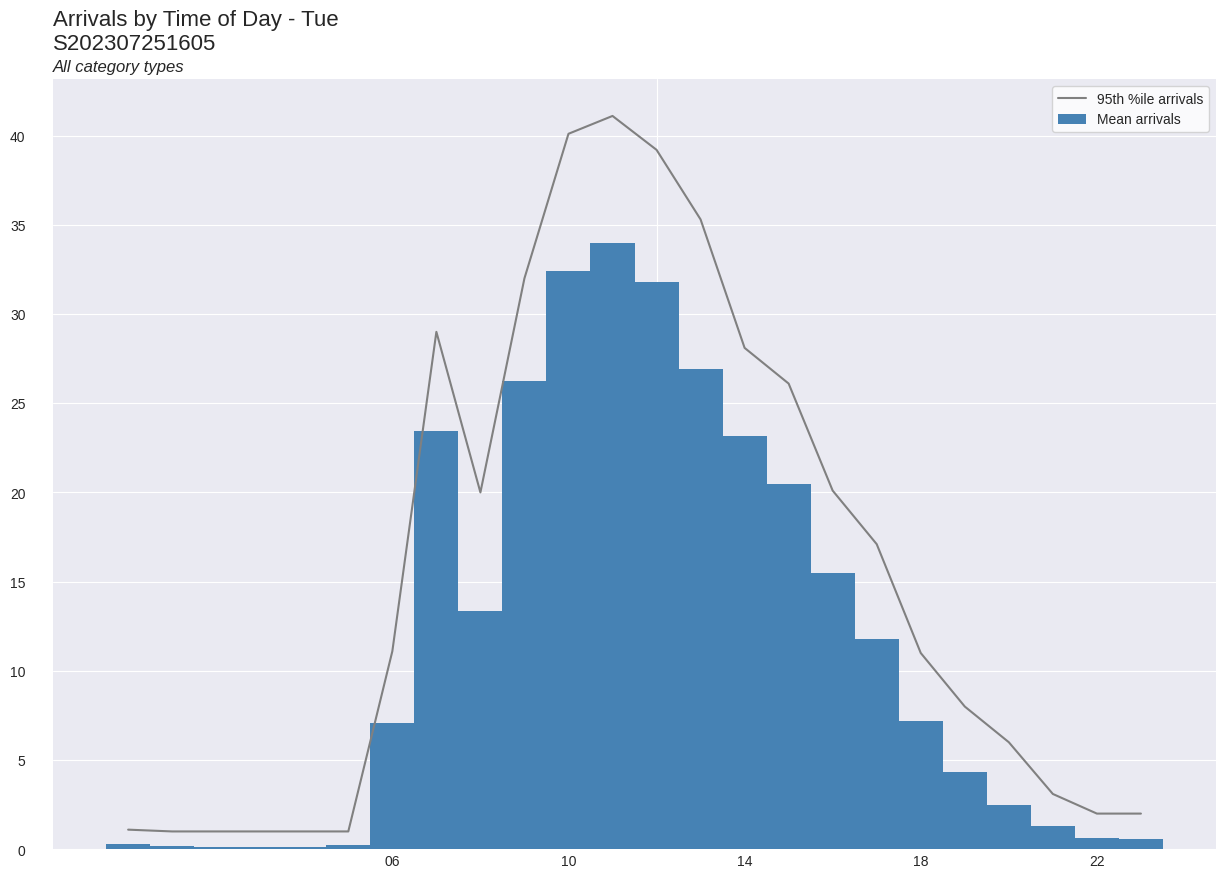

In [14]:
scenario_1.hills['plots']['s202307251605_arrivals_plot_Tue']

In [15]:
scenario_1.hills['summaries'].keys()

dict_keys(['nonstationary', 'stationary'])

In [16]:
scenario_1.hills['summaries']['nonstationary'].keys()

dict_keys(['PatType_dow_binofday', 'dow_binofday'])

In [17]:
scenario_1.hills['summaries']['nonstationary']['dow_binofday'].keys()

dict_keys(['occupancy', 'arrivals', 'departures'])

In [18]:
scenario_1.hills['summaries']['nonstationary']['dow_binofday']['occupancy']

count      mean  min  \
day_of_week dow_name bin_of_day bin_of_day_str                         
0           Mon      0          00:00            40.0  0.255000  0.0   
                     1          01:00            40.0  0.206667  0.0   
                     2          02:00            40.0  0.204167  0.0   
                     3          03:00            40.0  0.190000  0.0   
                     4          04:00            40.0  0.111250  0.0   
...                                               ...       ...  ...   
6           Sun      19         19:00            39.0  0.535470  0.0   
                     20         20:00            39.0  0.489316  0.0   
                     21         21:00            39.0  0.433761  0.0   
                     22         22:00            39.0  0.368376  0.0   
                     23         23:00            39.0  0.355983  0.0   

                                                     max     stdev       sem  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           1.833333  0.418453  0.066163   
                     1          01:00           1.600000  0.380785  0.060207   
                     2          02:00           0.916667  0.332665  0.052599   
                     3          03:00           1.133333  0.331142  0.052358   
                     4          04:00           1.000000  0.255910  0.040463   
...                                                  ...       ...       ...   
6           Sun      19         19:00           3.266667  0.747004  0.119616   
                     20         20:00           2.000000  0.596168  0.095463   
                     21         21:00           1.966667  0.463310  0.074189   
                     22         22:00           2.066667  0.510315  0.081716   
                     23         23:00           2.083333  0.493207  0.078976   

                                                     var        cv      skew  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           0.175103  1.640991  2.024153   
                     1          01:00           0.144997  1.842508  2.045914   
                     2          02:00           0.110666  1.629379  1.203569   
                     3          03:00           0.109655  1.742855  1.583843   
                     4          04:00           0.065490  2.300313  2.349720   
...                                                  ...       ...       ...   
6           Sun      19         19:00           0.558014  1.395043  1.813045   
                     20         20:00           0.355416  1.218370  1.119442   
                     21         21:00           0.214656  1.068124  1.194987   
                     22         22:00           0.260421  1.385309  1.608689   
                     23         23:00           0.243253  1.385478  1.578062   

                                                    kurt  p25       p50  \
day_of_week dow_name bin_of_day bin_of_day_str                            
0           Mon      0          00:00           4.603107  0.0  0.000000   
                     1          01:00           3.916359  0.0  0.000000   
                     2          02:00          -0.249311  0.0  0.000000   
                     3          03:00           1.181465  0.0  0.000000   
                     4          04:00           4.703609  0.0  0.000000   
...                                                  ...  ...       ...   
6           Sun      19         19:00           3.776304  0.0  0.150000   
                     20         20:00           0.457068  0.0  0.250000   
                     21         21:00           1.781882  0.0  0.333333   
                     22         22:00           2.409985  0.0  0.083333   
                     23         23:00           2.748971  0.0  0.000000   

                                                     

## Use case 2 - partition patient types into two holding areas
The hospital is considering sending some patient types to a new dedicated holding area. We want to be able to generate hillmaker outputs for various subsets of patients going to each of the two units.

In [19]:
stops_df['PatType'].unique()

array(['IVT', 'MYE', 'CAT', 'ART', 'OTH'], dtype=object)

In [20]:
a_subset = ['IVT', 'ART']

In [21]:
b_subset = [type for type in stops_df['PatType'].unique() if type not in a_subset]
b_subset

['MYE', 'CAT', 'OTH']

In [22]:
def which_holding_area(pat_type):
    if pat_type in a_subset:
        return 'unitA'
    else:
        return 'unitB'

In [23]:
stops_df['new_hold_area'] = stops_df['PatType'].map(lambda x: which_holding_area(x))

In [24]:
stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType,new_hold_area
0,1,1996-01-01 07:44:00,1996-01-01 08:50:00,IVT,unitA
1,2,1996-01-01 08:28:00,1996-01-01 09:20:00,IVT,unitA
2,3,1996-01-01 11:44:00,1996-01-01 13:30:00,MYE,unitB
3,4,1996-01-01 11:51:00,1996-01-01 12:55:00,CAT,unitB
4,5,1996-01-01 12:10:00,1996-01-01 13:00:00,IVT,unitA


In [25]:
stops_df['los'] = stops_df['OutRoomTS'] - stops_df['InRoomTS']

In [26]:
scenario02 = hm.HillsScenario(stops_df = stops_df, scenario_name = 'scenario02',
                              in_field = in_field_name, out_field = out_field_name,
                              start_analysis_dt = start_date, end_analysis_dt = end_date,
                              cat_field = 'new_hold_area')

In [27]:
scenario02.make_hills()

In [28]:
scenario02.hills['plots'].keys()

dict_keys(['scenario02_occupancy_plot_week', 'scenario02_arrivals_plot_week', 'scenario02_departures_plot_week', 'scenario02_occupancy_plot_Mon', 'scenario02_occupancy_plot_Tue', 'scenario02_occupancy_plot_Wed', 'scenario02_occupancy_plot_Thu', 'scenario02_occupancy_plot_Fri', 'scenario02_occupancy_plot_Sat', 'scenario02_occupancy_plot_Sun', 'scenario02_arrivals_plot_Mon', 'scenario02_arrivals_plot_Tue', 'scenario02_arrivals_plot_Wed', 'scenario02_arrivals_plot_Thu', 'scenario02_arrivals_plot_Fri', 'scenario02_arrivals_plot_Sat', 'scenario02_arrivals_plot_Sun', 'scenario02_departures_plot_Mon', 'scenario02_departures_plot_Tue', 'scenario02_departures_plot_Wed', 'scenario02_departures_plot_Thu', 'scenario02_departures_plot_Fri', 'scenario02_departures_plot_Sat', 'scenario02_departures_plot_Sun'])

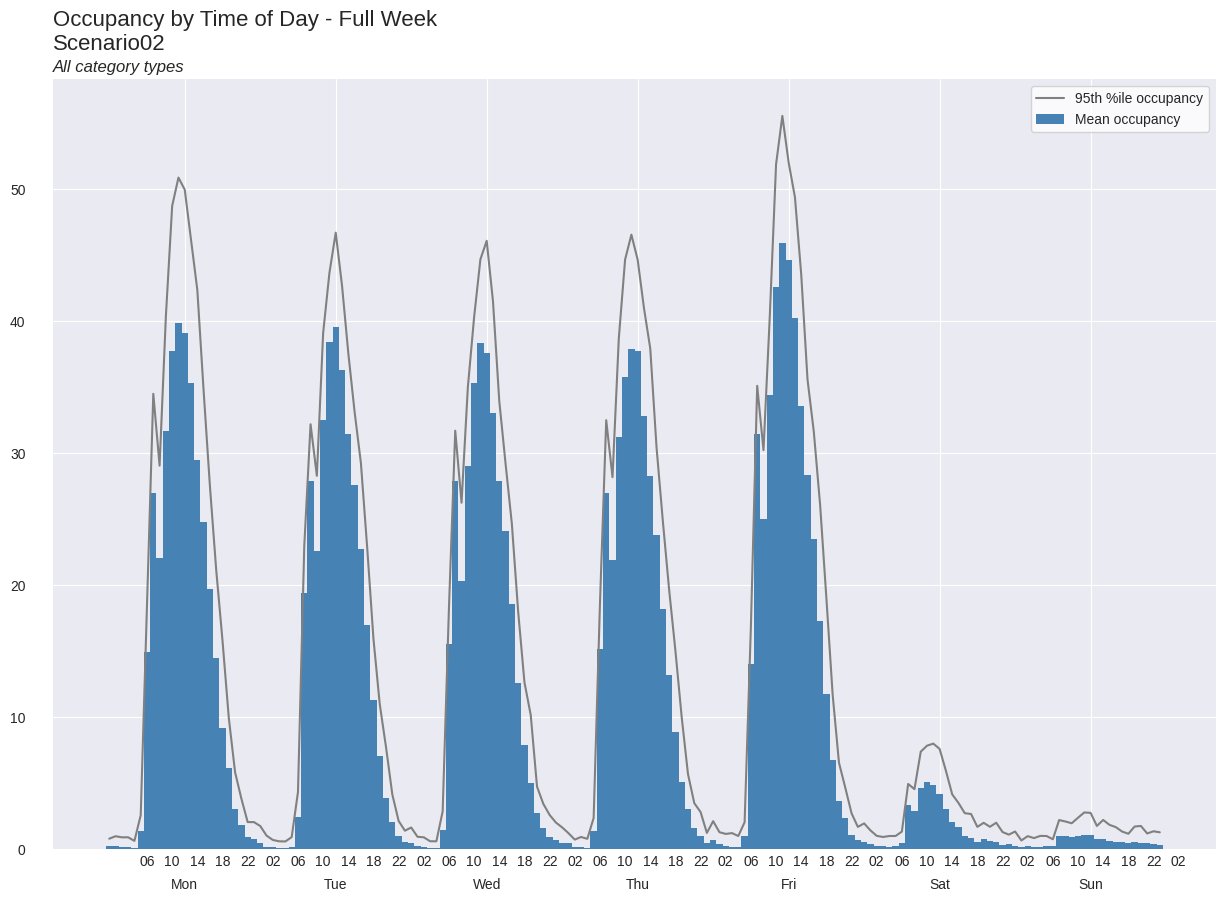

In [29]:
scenario02.hills['plots']['scenario02_occupancy_plot_week']

As part of an operational analysis we would like to compute a number of relevant statistics, such as:

- mean and 95th percentile of overall SSU occupancy by hour of day and day of week,
- similar hourly statistics for patient arrivals and departures,
- all of the above but by patient type as well.

In addition to tabular summaries, plots are needed. Like this:

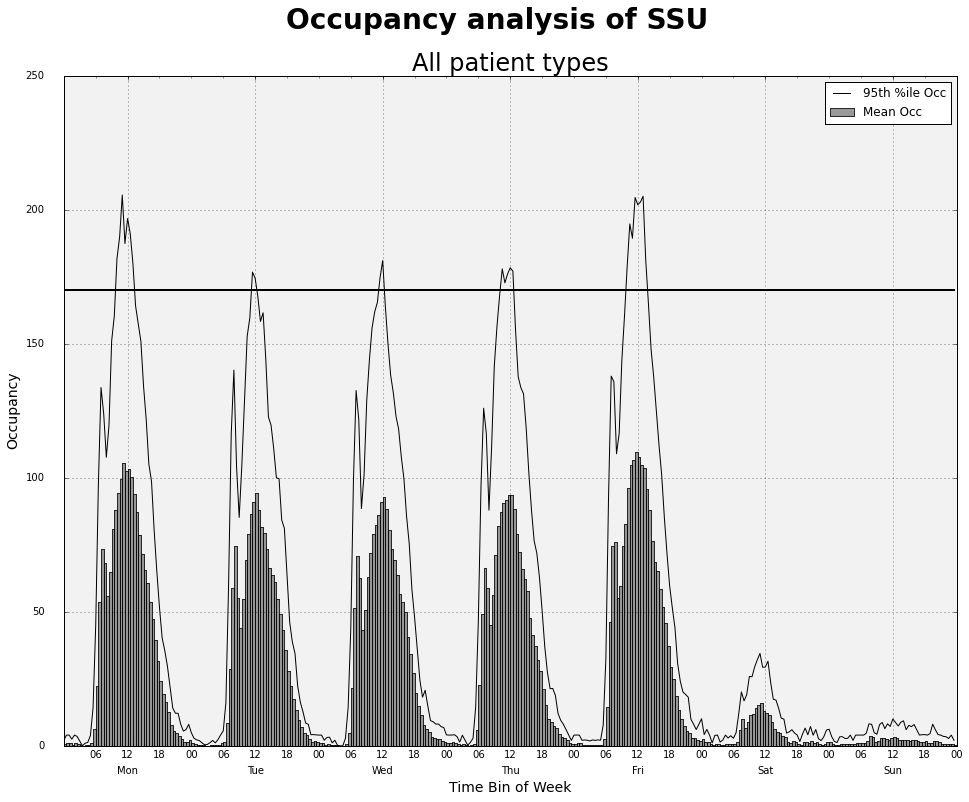

In [31]:
Image(filename="images/ssu-occ.png")

Hillmaker was designed for precisely this type of problem. In fact, the very first version of hillmaker was written for analyzing an SSU when the author was an undergraduate interning at a large health care system. That very first version was written in BASIC on a [DECwriter](https://en.wikipedia.org/wiki/DECwriter)!

In [ ]:
Image(filename="images/DECwriter,_Tektronix,_PDP-11_(192826605).jpg")

<p align = "center">
<font size="-2">Source: By Wolfgang Stief from Tittmoning, Germany - DECwriter, Tektronix, PDP-11, CC0, https://commons.wikimedia.org/w/index.php?curid=105322423</font>
</p>

Over the years, hillmaker was migrated to [FoxPro](https://en.wikipedia.org/wiki/FoxPro), and then to MS Access where it [lived for many years](http://hillmaker.sourceforge.net/). In 2016, I [moved it to Python](https://misken.github.io/blog/hillmaker-python-released/).